# dDR demo

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

from dDR.dDR import dDR
from dDR.utils.plotting import plot_stim_pair_dDR, compute_ellipse
from dDR.utils.decoding import compute_dprime

np.random.seed(123)

### Generate simulated spike count data
* 100 neurons ($N$), 200 repetitions ($k$), 4 stimuli ($S$)
* One latent, simulus-independent, noise dimension

In [23]:
# set data dimensions
N, k, S = 100, 200, 4

# Build rank 1 covariance matrix from latent variable
lv = np.abs(np.random.normal(1, 0.75, (N, 1))) #lv w/ mostly positive weights
lv = (lv / np.linalg.norm(lv)) * 2
cov = lv.dot(lv.T)

# add small random noise to covariance matrix to make full rank
cov += np.random.normal(0, 0.1, cov.shape)

# force to be positive semidefinite
cov = cov.dot(cov.T)

# define a dummy stimulus response -- each neuron responds differently to each stimulus -- 
# somewhat aligned with the latent "noise" dimensions
sdrive = np.abs(np.random.normal(0, 0.75, (N, S))).T # different "best" stimulus for each unit

# create data set from multivariate gaussian (neuron x rep x stimulus)
X = []
for s in range(S):  
    # get mean response to stimulus for each neuron
    u = sdrive[s, :]
    X.append(np.random.multivariate_normal(u, cov=cov, size=(k)))
X = np.stack(X).transpose([-1, 1, 0])

### Plot the simulated data

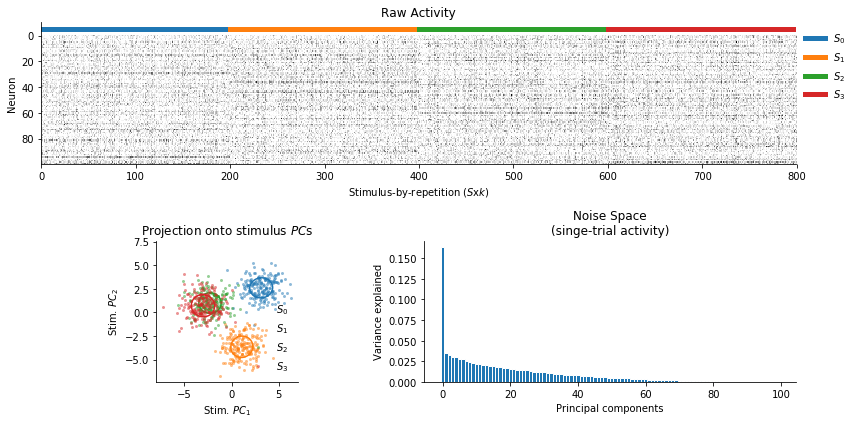

In [24]:
f = plt.figure(figsize=(12, 6))

rd = plt.subplot2grid((2, 2), (0, 0), colspan=2) # display "raw" data
pcplot = plt.subplot2grid((2, 2), (1, 0))        # plot "responses" in PC space, for visualization
Nscree = plt.subplot2grid((2, 2), (1, 1))        # plot the variance explained by each stimulus-independent PC

# plot the data (mean responses)
rd.imshow(X.transpose([0, 2, 1]).reshape(N, -1), aspect='auto', cmap='Greys', vmin=0)
for i in range(S):
    rd.plot(np.arange(i*k, (i+1)*k), (-5)*np.ones(k), lw=5, label=r"$S_{%s}$"%i)
rd.legend(frameon=False, bbox_to_anchor=(1, 1))
rd.set_xlabel(r'Stimulus-by-repetition ($S$x$k$)')
rd.set_ylabel('Neuron')
rd.set_title('Raw Activity')

# Plot single trial data in the "stimulus space" (first two PCs of trial averaged activity)
Xu = X.mean(axis=1, keepdims=True)
evals, evecs = np.linalg.eig(np.cov(Xu.squeeze()))
idx = np.argsort(evals)[::-1]
evals = evals[idx]; evecs[:, idx]
proj = (X - X.mean(keepdims=True)).T.dot(evecs[:, 0:2])
for sr in range(proj.shape[0]):
    pcplot.plot(proj[sr, :, 0], proj[sr, :, 1], '.', label=r"$S_{%s}$"%sr, alpha=0.5, markeredgecolor='none')
    x, y = compute_ellipse(proj[sr, :, 0], proj[sr, :, 1])
    pcplot.plot(x, y, color=pcplot.get_lines()[-1].get_color())
pcplot.set_xlabel(r"Stim. $PC_1$")
pcplot.set_ylabel(r"Stim. $PC_2$")
pcplot.set_title(r"Projection onto stimulus $PC$s")
pcplot.legend(frameon=False)
pcplot.axis('square')

# scree plot of noise space
Xcenter = X - Xu
evals, evecs = np.linalg.eig(np.cov(Xcenter.reshape(N, -1)))
idx = np.argsort(evals)[::-1]
evals = evals[idx]; evecs[:, idx]
Nscree.bar(np.arange(len(evals)), evals / evals.sum(), 
                width=1, edgecolor='white')
Nscree.set_title("Noise Space\n(singe-trial activity)")
Nscree.set_ylabel("Variance explained")
Nscree.set_xlabel("Principal components")

f.tight_layout()

### Perform decoding analysis using $dDR$
* We will focus on just a single pair of stimuli, $S_1$ and $S_2$

#### Step 1:
* Define response matrices $S_1$ and $S_2$

In [25]:
S1 = X[:, :, 1] # Activity during stimulus condition 1
S2 = X[:, :, 2] # Activity during stimulus condition 2

#### Step 2:
* Split data 50/50 for estimation and validation sets for cross-validation

In [26]:
eidx = np.random.choice(np.arange(k), int(k/2), replace=False)
vidx = np.array(list(set(np.arange(k)).difference(eidx)))
S1_est = S1[:, eidx]
S2_est = S2[:, eidx]
S1_val = S1[:, vidx]
S2_val = S2[:, vidx]

#### Step 3:
* Perform dimensionality reduction using $dDR$

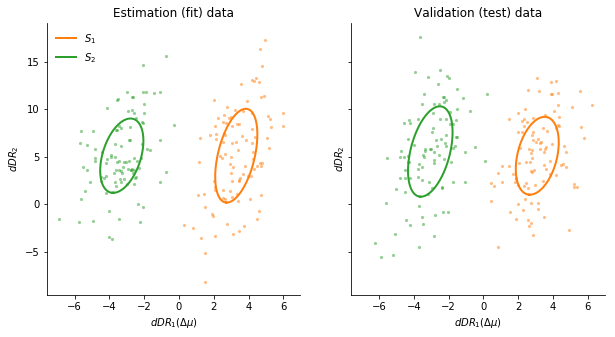

In [27]:
# make dDR object
ddr = dDR()

# fit dDR to estimation data (needs to be shape <Observation X Neuron>), and project estimation data onto the new basis
S1_est_ddr, S2_est_ddr = ddr.fit_transform(S1_est.T, S2_est.T)

# also project validation data into ddr space
S1_val_ddr = ddr.transform(S1_val.T)
S2_val_ddr = ddr.transform(S2_val.T)

# plot the data
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].set_title("Estimation (fit) data")
plot_stim_pair_dDR(S1_est_ddr, S2_est_ddr, 
                    lab1=r"$S_{1}$", lab2=r"$S_{2}$", 
                    c1='tab:orange', c2='tab:green',
                    lw=2, alpha=0.5,
                    ax=ax[0])
ax[1].set_title("Validation (test) data")
plot_stim_pair_dDR(S1_val_ddr, S2_val_ddr, 
                    c1='tab:orange', c2='tab:green',
                    lw=2, alpha=0.5,
                    ax=ax[1])


#### Step 4:
* Measure decoding accuracy. 
    * We will use $d'^2$ as our decoding metric (ADD CITATION). 


Text(0.5, 0, 'Projection of spike counts onto $\\mathbf{w}_{opt}$')

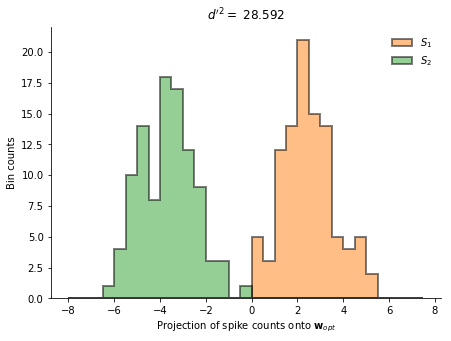

In [28]:
# fit decoding axis on est data, NOTE: matrices must be shape Dimension X Repetition 
est_results = compute_dprime(S1_est_ddr.T, S2_est_ddr.T) 
# evaluate on est data by projecting onto optimal decoding axis (wopt)
val_results = compute_dprime(S1_val_ddr.T, S2_val_ddr.T, wopt=est_results.wopt)

# to visualize, project the data onto the decoding axis, wopt
bins = np.arange(-8, 8, 0.5)
s1 = S1_val_ddr.dot(est_results.wopt / np.linalg.norm(est_results.wopt))
s2 = S2_val_ddr.dot(est_results.wopt / np.linalg.norm(est_results.wopt))

f, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.hist(s1, bins=bins, histtype='stepfilled', edgecolor='k', lw=2, alpha=0.5, color='tab:orange', label=r"$S_1$")
ax.hist(s2, bins=bins, histtype='stepfilled', edgecolor='k', lw=2, alpha=0.5, color='tab:green', label=r"$S_2$")
ax.legend(frameon=False)
ax.set_title(r"$d'^2 = $ %s" % round(val_results.dprimeSquared, 3))
ax.set_ylabel("Bin counts")
ax.set_xlabel(r"Projection of spike counts onto $\mathbf{w}_{opt}$")


### Note, we include `dDR.utils.decoding.compute_dprime` as a general purpose function for optimal linear decoding. For a pair of e.g. stimuli ($S_1$ and $S_2$), the function returns: 

1) Stimulus discriminability, $d'^2$

2) The optimal linear decoding axis, $\mathbf{w}_{opt}$

3) The eigenvalues, $\lambda$, and eigenvectors, $\mathbf{e}$, of the stimulus-independent covariance matrix, $\Sigma = \frac{1}{2} (\Sigma_1 + \Sigma_2)$

4) The similarity between the eigenvectors of $S_1$ and $S_2$ 

5) The signal axis, $\Delta \mathbf{\mu} = \mu_1 - \mu_2$, where $\mu_1$ and $\mu_2$ are the mean responses under conditions 1 and 2, respectively